<a href="https://colab.research.google.com/github/merucode/RL/blob/92-Project-Trader-Custom_environment/01_Creating_a_Gym_Environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP 1. Install Dependency

In [1]:
!git clone -b 92-Project-Trader-Custom_environment https://github.com/merucode/RL.git
!cd RL && mv * ../

Cloning into 'RL'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 101 (delta 5), reused 0 (delta 0), pack-reused 80
Receiving objects: 100% (101/101), 228.39 KiB | 5.19 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [2]:
!pip install -e trader_world

Obtaining file:///content/trader_world
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 38.0 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.0
    Uninstalling pygame-2.5.0:
      Successfully uninstalled pygame-2.5.0
  Running setup.py develop for trader-world


### NOTE: After inistall gym-examples, Restart runtime

# STEP 2. trader_world.py



In [ ]:
import gym
from gym import spaces
import pygame
import numpy as np

BLACK = pygame.Color(0, 0, 0)
WHITE = pygame.Color(255, 255, 255)
RED = pygame.Color(255, 0, 0)
GREEN = pygame.Color(0, 255, 0)
BLUE = pygame.Color(0, 0, 255)
YELLOW = pygame.Color(255, 255, 0)

"""
    ### Parameter
    * df : Series trade pd.DataFrame witch consist of ohlcv columns(open, high, low, close, volume)
         : It is Sorted by time ascending order
    * obs_len : What want to observate lenth from df
    * actions : The number of discrete action space
    * df_render : If you have preprocessing df and want to render with original df, use obs_df with original df

    ### Argument
    ...

    ### Method
    ...

    ### Action Space
    The action space is a `Discrete(actions)`
    | Num | Action                                                            |
    | --- | ----------------------------------------------------------------- |
    | 0   | Hold                                                              |
    | 1   | Buy coin and sell coin after 1 step                               |
    | 2   | Buy coin and sell coin after 2 step                               |
    ...
    | n   | Buy coin and sell coin after n step                               |


    ### Observation Space
    The observation space is a `Box(0, np.inf, (self.obs_len, 4), int)`. Each Num mean 1-dimension number
    | Num | Observation                                                  | Min    | Max    |
    |-----|--------------------------------------------------------------|--------|--------|
    | 0   | open                                                         | 0      | Inf    |
    | 1   | high                                                         | 0      | Inf    |
    | 2   | low                                                          | 0      | Inf    |
    | 3   | close                                                        | 0      | Inf    |
    | 4   | volume                                                       | 0      | Inf    |

    ### Reward
    Profit
"""

class TraderWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, df, df_render=None, obs_len=30, actions=10, render_mode=None):
        self.df = df
        self.lst_ohlcv = self.df_to_lst(self.df)    # convert DataFrame to list
        self.obs_len = obs_len
        self.time_step_limit = len(self.df) - self.obs_len - actions

        self.df_render = df_render if df_render is not None else df
        self.lst_ohlcv_render = self.df_to_lst(self.df_render)

        self.window_size_x = 900        # The size of the PyGame window
        self.window_size_y = 1500
        self.candle_frame_size_x = 900  # The size of the candle frame
        self.candle_frame_size_y = 900
        self.volume_frame_size_x = 900  # The volume of the candle frame
        self.volume_frame_size_y = 500
        self.score_frame_size_x = 900   # The score of the candle frame
        self.score_frame_size_y = 100

        # Observations are ohlcv data with obeservation lenth
        self.observation_space = spaces.Box(0, np.Inf, shape=(self.obs_len, 5), dtype=int)

        # We have 10 actions(each action is differe)
        self.action_space = spaces.Discrete(actions)

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

    def _action_to_trade(self, action):
        if action == 0:
            profit = 0
        else:
            # Buy close price. After action value tiem step, sell low price(conservative profit)
            buy_price = self.lst_ohlcv[self.time_step + self.obs_len - 1][3]
            sell_price = self.lst_ohlcv[self.time_step + self.obs_len - 1 + action][2]
            # trading_fee = buy_price*(0.015_증권사수수료)*0.01 + sell_price*(0.015_증권사수수료+0.3_세금)*0.01
            trading_fee = buy_price*0.015*0.01 + sell_price*(0.015+0.3)*0.01
            trading_fee = round(trading_fee)

            # profit = -1 * buy_close_price + sell_low_price - trade_fee
            profit = -1 * buy_price + sell_price - trading_fee
        return profit, buy_price, sell_price, trading_fee

    def _get_obs(self):
        return self.lst_ohlcv[self.time_step:self.time_step + self.obs_len]

    def _get_obs_render(self):
        return self.lst_ohlcv_render[self.time_step:self.time_step + self.obs_len]

    #def _get_info(self):
    #    return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}


    def reset(self, seed=None, options=None):
        self.time_step = 0

        self.balance = 100000

        observation = self._get_obs()
        #info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation


    def step(self, action):
        profit, buy_price, sell_price, trading_fee = self._action_to_trade(action)

        self.balance = self.balance + profit

        terminated = 1 if (self.balance <= 0 or self.time_step==self.time_step_limit) else 0

        reward = profit / 100

        observation = self._get_obs()
        #info = self._get_info()
        info = {'balance':self.balance, 'buy_price':buy_price, 'sell_price':sell_price, 'traing_fee':trading_fee,
                'time_step':self.time_step, 'time_step_limit':self.time_step_limit}

        if self.render_mode == "human":
            self._render_frame()

        self.time_step += 1
        return observation, reward, terminated, False, info


    ########################## RENDER ##########################
    def render(self):
        if self.render_mode == "rgb_array":
            pygame.font.init()  # For display score
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size_x, self.window_size_y))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size_x, self.window_size_y))
        canvas.fill(WHITE)

        score_frame = pygame.Surface((self.score_frame_size_x, self.score_frame_size_y))
        score_frame_rect = score_frame.get_rect()
        score_frame_rect.top = 0
        score_frame_rect.left = 0
        score_frame.fill(BLACK)
        score_font = pygame.font.SysFont('arial', 80)
        score_image = score_font.render(f'{self.balance}', True, YELLOW)
        score_frame.blit(score_image, (10, 10))
        canvas.blit(score_frame, (0, 0))
        # Candle Plot
        candle_frame = self._render_candle()
        canvas.blit(candle_frame, (0, 100))
        # Bar Plot
        volume_frame = self._render_volume()
        canvas.blit(volume_frame, (0, 1000))

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def _render_candle(self):
        candle_frame = pygame.Surface((self.candle_frame_size_x, self.candle_frame_size_y))
        candle_frame.fill(BLACK)
        candle_width = self.candle_frame_size_x // self.obs_len
        candle_line_space = (candle_width // 2) - 1
        candle_line_width = 2

        observation_render = self._get_obs_render()
        scale_ohlc_lst_render = self._get_scale_ohlc_lst_render(observation_render, new_range=self.candle_frame_size_y)

        for idx in range(len(scale_ohlc_lst_render)):
            candle_x = idx * candle_width
            candle_y = self.candle_frame_size_y - max(scale_ohlc_lst_render[idx][0], scale_ohlc_lst_render[idx][3])
            candle_height = abs(scale_ohlc_lst_render[idx][0] - scale_ohlc_lst_render[idx][3])

            candle_line_y = self.candle_frame_size_y - scale_ohlc_lst_render[idx][1]
            candle_line_height = scale_ohlc_lst_render[idx][1] - scale_ohlc_lst_render[idx][2]

            if scale_ohlc_lst_render[idx][0] == scale_ohlc_lst_render[idx][3]:
                candle_height = 2
                pygame.draw.rect(candle_frame, RED,
                                 pygame.Rect(candle_x , candle_y, candle_width, candle_height)) # candle
                pygame.draw.rect(candle_frame, RED,
                                 pygame.Rect(candle_x + candle_line_space, candle_line_y, candle_line_width, candle_line_height)) # candle line
            elif scale_ohlc_lst_render[idx][0] < scale_ohlc_lst_render[idx][3]:
                pygame.draw.rect(candle_frame, RED,
                                 pygame.Rect(candle_x , candle_y, candle_width, candle_height))
                pygame.draw.rect(candle_frame, RED,
                                 pygame.Rect(candle_x + candle_line_space, candle_line_y, candle_line_width, candle_line_height)) # candle line
            else:
                pygame.draw.rect(candle_frame, BLUE,
                                 pygame.Rect(candle_x , candle_y, candle_width, candle_height))
                pygame.draw.rect(candle_frame, BLUE,
                                 pygame.Rect(candle_x + candle_line_space, candle_line_y, candle_line_width, candle_line_height)) # candle line

        return candle_frame


    def _render_volume(self):
        volume_frame = pygame.Surface((self.volume_frame_size_x, self.volume_frame_size_y))
        volume_frame.fill(BLACK)

        volume_width = self.volume_frame_size_x // self.obs_len

        observation_render = self._get_obs_render()
        scale_v_lst_render = self._get_scale_v_lst_render(observation_render, new_range=self.volume_frame_size_y)

        for idx in range(len(scale_v_lst_render)):
            volume_x = idx * volume_width
            volume_height = scale_v_lst_render[idx][0]
            volume_y = self.volume_frame_size_y - volume_height

            pygame.draw.rect(volume_frame, GREEN,
                                 pygame.Rect(volume_x , volume_y, volume_width, volume_height)) # candle
        return volume_frame


    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

    ########################## Util ##########################
    def df_to_lst(self, df):
        lst = []
        for i in range(len(df)):
            lst.append(df.iloc[i].tolist())
        return lst

    def _get_scale_ohlc_lst_render(self, ohlcv_lst, new_range):
        ohlc_lst = []
        for idx in range(len(ohlcv_lst)):
            ohlc_lst.append(ohlcv_lst[idx][0:4])
        ohlc_scale_lst = self._min_max_scale_lst(ohlc_lst, new_range)
        return ohlc_scale_lst

    def _get_scale_v_lst_render(self, ohlcv_lst, new_range):
        v_lst = []
        for idx in range(len(ohlcv_lst)):
            v_lst.append(ohlcv_lst[idx][-1:])
        v_scale_lst = self._min_max_scale_lst(v_lst, new_range, old_min=0)
        return v_scale_lst

    def _min_max_scale_lst(self, lst, new_range, old_min=None, old_max=None):
        old_min = min(map(min, lst)) if old_min is None else old_min # min from 2-dimension list
        old_max = max(map(max, lst)) if old_max is None else old_max # max from 2-dimension list
        new_lst = []
        new_sub_lst = []
        for sub_lst in lst:
            new_sub_lst = []
            for value in sub_lst:
                scaled_value = self._max_min_scale_value(value, old_min, old_max, new_range=new_range)
                new_sub_lst.append(scaled_value)
            new_lst.append(new_sub_lst)

        return new_lst

    def _max_min_scale_value(self,value, old_min, old_max, new_range=1):
        scaled_value = (value - old_min) / (old_max - old_min) * new_range
        scaled_value = round(scaled_value)
        return scaled_value

# STEP 3. Test Code

In [2]:
!pip install pykrx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 9.7 MB/s eta 0:00:00


In [7]:
!pip install -e trader_world

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Obtaining file:///content/trader_world
  Preparing metadata (setup.py) ... done
  Attempting uninstall: trader-world
    Found existing installation: trader-world 0.0.1
    Uninstalling trader-world-0.0.1:
      Successfully uninstalled trader-world-0.0.1
  Running setup.py develop for trader-world


After install env, Restart runtime

In [7]:
### Ready data
from pykrx import stock
import pandas as pd

df = stock.get_market_ohlcv("20210701", "20210827", "005930")
df = df[df.columns.tolist()[:-1]]
df.columns = ['open', 'high', 'low', 'close', 'volume']

df = df.reset_index(drop=True)
print(df.head(3))
print(len(df))

    open   high    low  close    volume
0  80500  80600  80000  80100  13382882
1  80000  80400  79900  80000   8753097
2  80100  80800  80000  80400   8330969
41


In [14]:
import time
import matplotlib.pyplot as plt
import gym

env = gym.make("trader_world:TraderWorld-v0", df=df, df_render=df, obs_len=30, actions=10, render_mode="rgb_array")

In [15]:
env.reset()

[[80500, 80600, 80000, 80100, 13382882],
 [80000, 80400, 79900, 80000, 8753097],
 [80100, 80800, 80000, 80400, 8330969],
 [80600, 81200, 80500, 81200, 12131651],
 [81200, 81300, 80300, 80800, 15992202],
 [81100, 81200, 79900, 79900, 16660998],
 [79600, 79800, 79000, 79400, 22720577],
 [79900, 80000, 79500, 79700, 9768108],
 [80000, 80200, 79800, 79800, 9863450],
 [79400, 79600, 79100, 79500, 11575636],
 [79800, 80600, 79500, 80600, 13766279],
 [80100, 80100, 79500, 79800, 10859399],
 [79100, 79200, 78800, 79000, 13155414],
 [78500, 79000, 78400, 79000, 12456646],
 [79000, 79100, 78500, 78500, 12355296],
 [79000, 79800, 78900, 79700, 12618790],
 [79700, 79900, 79200, 79300, 9098910],
 [79400, 79500, 78800, 78800, 10040975],
 [79200, 79400, 78500, 78500, 11427693],
 [78300, 79200, 78100, 79200, 12743417],
 [78800, 79400, 78800, 79000, 14360453],
 [78900, 78900, 78500, 78500, 13823411],
 [79200, 79500, 78700, 79300, 11739124],
 [79400, 81400, 79300, 81400, 24339360],
 [82200, 83100, 81800

In [16]:
env.action_space, env.observation_space

(Discrete(10), Box(0, 9223372036854775805, (30, 5), int64))

In [17]:
action = env.action_space.sample()
action

2

In [19]:
obs, reward, done, info = env.step(5)
print(reward, done, info)

-47.4 1 {'balance': 89618, 'buy_price': 77000, 'sell_price': 72500, 'traing_fee': 240, 'time_step': 1, 'time_step_limit': 1, 'TimeLimit.truncated': False}


In [26]:
print(reward)
df[30:40]

-1051


,open,high,low,close,volume
30,76700,77100,75900,76800,16114775
31,76800,76800,75700,76000,15347486
32,76400,76700,76000,76600,12096419
33,76800,77600,76600,77300,12861180
34,77100,77100,75900,76100,13239401
35,76000,76400,75600,76300,11798147
36,76400,76600,75000,75300,17600770
37,75300,75600,74800,75300,10103212
38,75200,76300,75100,76300,11397775
39,77100,77700,76600,76600,18167057


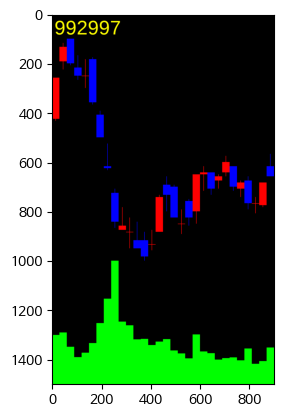

In [18]:
img = env.render()
plt.figure()
plt.imshow(img)

# STEP. Test Data

In [9]:
### Ready data
from pykrx import stock
import pandas as pd

df = stock.get_market_ohlcv("20210720", "20221010", "005930")
df = df[df.columns.tolist()[:-1]]
df.columns = ['open', 'high', 'low', 'close', 'volume']

df = df.reset_index(drop=True)
print(df.head(3))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


    open   high    low  close    volume
0  78500  79000  78400  79000  12456646
1  79000  79100  78500  78500  12355296
2  79000  79800  78900  79700  12618790


In [11]:
def df_to_lst(df):
    lst = []
    for i in range(len(df)):
        lst.append(df.iloc[i].tolist())
    return lst

In [19]:
test_lst = df_to_lst(df)

In [34]:
ohlc_lst = _get_scale_ohlc_lst(test_lst)
v_lst = _get_scale_v_lst(test_lst)
print(ohlc_lst)
print(v_lst)

[2, 6, 0, 4]
[[12], [12], [12], [6], [8], [10], [13], [15], [15], [11], [33], [36], [23], [14], [18], [26], [44], [66], [100], [45], [42], [30], [30], [25], [27], [30], [20], [17], [12], [34], [19], [17], [11], [13], [13], [11], [21], [8], [10], [22], [13], [13], [19], [20], [12], [11], [17], [33], [25], [18], [33], [24], [14], [15], [45], [33], [25], [22], [14], [7], [8], [9], [5], [8], [9], [8], [27], [20], [10], [20], [13], [11], [12], [10], [10], [7], [10], [8], [12], [9], [9], [8], [11], [39], [29], [18], [12], [13], [20], [44], [29], [32], [23], [19], [24], [28], [29], [6], [17], [9], [7], [11], [13], [10], [15], [20], [14], [11], [9], [22], [25], [15], [14], [12], [35], [13], [17], [8], [13], [9], [15], [8], [5], [7], [9], [7], [18], [14], [22], [13], [30], [28], [22], [13], [15], [11], [7], [22], [12], [15], [6], [9], [14], [8], [9], [11], [8], [18], [13], [22], [12], [13], [14], [23], [18], [28], [18], [6], [8], [8], [21], [16], [10], [7], [12], [58], [13], [12], [14], [12], [

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Appendix. B/U gird_world.py

In [ ]:
import gym
from gym import spaces
import pygame
import numpy as np


class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
        self.size = size        # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None


    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location}

    def _get_info(self):
        return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}


    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # We will sample the target's location randomly until it does not coincide with the agent's location
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info


    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        # An episode is done iff the agent has reached the target
        terminated = np.array_equal(self._agent_location, self._target_location)
        reward = 1 if terminated else 0  # Binary sparse rewards
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info


    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )


    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()